In [1]:
import asyncio
import os

from collections import Counter
from datetime import datetime
from pathlib import Path

import duckdb
import httpx
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sns

%load_ext sql

from dotenv import load_dotenv

load_dotenv()

DB_PATH = Path(".").absolute().parent / Path(os.getenv("SILVER_DUCKDB_PATH", ""))

TMP_DIR = "/tmp/duckdb_tmp"

OUT_DIR = Path("outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

NODES_CSV = OUT_DIR / "camara_bipartite_nodes.csv"
EDGES_CSV = OUT_DIR / "camara_bipartite_edges.csv"

conn = duckdb.connect(DB_PATH)

conn.execute(f"SET temp_directory='{TMP_DIR}'")
conn.execute("SET memory_limit='50GB'")
conn.execute("SET threads=1")
conn.execute("SET preserve_insertion_order=false")

plt.rcParams["figure.dpi"] = 150
plt.rcParams["figure.figsize"] = (6, 4)
sns.set_style("darkgrid")

%sql conn --alias duck


Tip: You may define configurations in /home/c-cc2016/ra173608/tramita/pyproject.toml or /home/c-cc2016/ra173608/.jupysql/config.

Did not find user configurations in /home/c-cc2016/ra173608/tramita/pyproject.toml.

# Carregamento dos dados

## Proposições

In [2]:
%%sql
SELECT
  id_proposicao,
  uri,
  CASE
    WHEN REGEXP_FULL_MATCH(uri, '.*/deputados/[0-9]+$') THEN 'deputado'
    WHEN REGEXP_FULL_MATCH(uri, '.*/orgaos/[0-9]+$')    THEN 'orgao'
    ELSE 'unknown'
  END AS author_type,
  REGEXP_EXTRACT(uri, '.*/(deputados|orgaos)/([0-9]+)$', 1) AS uri_kind,      -- 'deputados' or 'orgaos'
  REGEXP_EXTRACT(uri, '.*/(deputados|orgaos)/([0-9]+)$', 2) AS author_id_str, -- numeric id as text
  TRY_CAST(REGEXP_EXTRACT(uri, '.*/(deputados|orgaos)/([0-9]+)$', 2) AS BIGINT) AS author_id_num
FROM autores_camara
WHERE uri <> ''
LIMIT 50;


Running query in 'duck'

id_proposicao,uri,author_type,uri_kind,author_id_str,author_id_num
15009,https://dadosabertos.camara.leg.br/api/v2/deputados/73538,deputado,deputados,73538,73538
15532,https://dadosabertos.camara.leg.br/api/v2/deputados/73910,deputado,deputados,73910,73910
15749,https://dadosabertos.camara.leg.br/api/v2/deputados/74316,deputado,deputados,74316,74316
15990,https://dadosabertos.camara.leg.br/api/v2/orgaos/262,orgao,orgaos,262,262
16481,https://dadosabertos.camara.leg.br/api/v2/orgaos/78,orgao,orgaos,78,78
16969,https://dadosabertos.camara.leg.br/api/v2/orgaos/78,orgao,orgaos,78,78
17563,https://dadosabertos.camara.leg.br/api/v2/deputados/73788,deputado,deputados,73788,73788
17823,https://dadosabertos.camara.leg.br/api/v2/deputados/74671,deputado,deputados,74671,74671
17915,https://dadosabertos.camara.leg.br/api/v2/orgaos/78,orgao,orgaos,78,78
18420,https://dadosabertos.camara.leg.br/api/v2/deputados/73458,deputado,deputados,73458,73458


## Autores

In [3]:
%%sql
CREATE OR REPLACE VIEW camara_authors AS
SELECT
  CAST(id_proposicao AS BIGINT) AS id_proposicao,
  REGEXP_EXTRACT(uri, '.*/(deputados|orgaos)/([0-9]+)$', 1) AS uri_kind,
  TRY_CAST(REGEXP_EXTRACT(uri, '.*/(deputados|orgaos)/([0-9]+)$', 2) AS BIGINT) AS author_id_num
FROM autores_camara
WHERE uri IS NOT NULL;

Running query in 'duck'

Count


In [4]:
%%sql
SELECT * FROM camara_authors LIMIT 10;

Running query in 'duck'

id_proposicao,uri_kind,author_id_num
15009,deputados,73538
15532,deputados,73910
15749,deputados,74316
15990,orgaos,262
16481,orgaos,78
16969,orgaos,78
17563,deputados,73788
17823,deputados,74671
17915,orgaos,78
18420,deputados,73458


### Checagem de autores órfãos (indexados na relacional mas sem presença no BD)

In [5]:
%%sql
WITH orphan_ids AS (
  SELECT DISTINCT a.author_id_num AS id_deputado
  FROM camara_authors a
  LEFT JOIN deputados_camara d
    ON d.id_deputado = a.author_id_num
  WHERE a.uri_kind = 'deputados' AND d.id_deputado IS NULL
),
cnt AS (SELECT COUNT(*) AS n FROM orphan_ids)
-- returns 1 if OK; raises divide-by-zero error if any orphan exists
SELECT 1 / (CASE WHEN n = 0 THEN 1 ELSE 0 END) AS ok_zero_orphans
FROM cnt;

Running query in 'duck'

ok_zero_orphans
1.0


In [6]:
%%sql
WITH orphan_ids AS (
  SELECT DISTINCT a.author_id_num AS id_orgao
  FROM camara_authors a
  LEFT JOIN orgaos_camara o
    ON o.id_orgao = a.author_id_num
  WHERE a.uri_kind = 'orgaos' AND o.id_orgao IS NULL
),
cnt AS (SELECT COUNT(*) AS n FROM orphan_ids)
-- returns 1 if OK; raises divide-by-zero error if any orphan exists
SELECT 1 / (CASE WHEN n = 0 THEN 1 ELSE 0 END) AS ok_zero_orphans
FROM cnt;

WITH orphan_ids AS (
  SELECT DISTINCT a.author_id_num AS id_orgao
  FROM camara_authors a
  LEFT JOIN orgaos_camara o
    ON o.id_orgao = a.author_id_num
  WHERE a.uri_kind = 'orgaos' AND o.id_orgao IS NULL
)
SELECT * FROM orphan_ids LIMIT 100;

Running query in 'duck'

id_orgao
262
5996
6502
6726
81
537485
537337
537914
537742
538202


In [7]:
%%sql

CREATE OR REPLACE VIEW missing_orgaos AS
WITH refs AS (
  SELECT DISTINCT author_id_num AS id_orgao
  FROM camara_authors
  WHERE uri_kind = 'orgaos'
),
have AS (
  SELECT DISTINCT id_orgao FROM orgaos_camara
)
SELECT r.id_orgao
FROM refs r
LEFT JOIN have h ON h.id_orgao = r.id_orgao
WHERE h.id_orgao IS NULL;


Running query in 'duck'

Count


In [8]:
%%sql
SELECT COUNT(*) AS n_missing FROM missing_orgaos;

Running query in 'duck'

n_missing
62


### Complementação de dados faltantes

In [9]:
missing = conn.execute("SELECT id_orgao FROM missing_orgaos").df().id_orgao.to_list()
missing

[262,
 5996,
 6502,
 6726,
 81,
 537485,
 537337,
 537914,
 537742,
 538202,
 101347,
 57,
 101489,
 102133,
 102346,
 371,
 80,
 6914,
 382,
 275,
 101131,
 277,
 9140,
 537484,
 537487,
 537731,
 537931,
 79,
 60,
 6994,
 479,
 5498,
 6415,
 9071,
 82,
 537273,
 271,
 538490,
 538297,
 101772,
 6987,
 266,
 476,
 276,
 279,
 284,
 5495,
 5364,
 5560,
 6115,
 6281,
 6462,
 6697,
 537127,
 6303,
 537389,
 101798,
 537939,
 10119,
 539426,
 539461,
 101582]

In [10]:
async def fetch_orgao(orgao_id: int, sem: asyncio.Semaphore, client: httpx.AsyncClient):
    async with sem:
        for _ in range(10):
            try:
                print(orgao_id)
                response = await client.get(f"https://dadosabertos.camara.leg.br/api/v2/orgaos/{orgao_id}")
                response.raise_for_status()
                data = response.json()
                return data
            except Exception:
                print(f"Retrying {orgao_id}...")
                await asyncio.sleep(3)
    
sem = asyncio.Semaphore(10)

async with httpx.AsyncClient() as client:
    tasks = [fetch_orgao(oid, sem, client) for oid in missing]
    result = await asyncio.gather(*tasks, return_exceptions=True)

262
5996
6502
6726
81
537485
537337
537914
537742
538202
101347
57
101489
102133
102346
371
80
6914
382
275
101131
277
9140
537484
537487
537731
537931
79
60
6994
479
5498
6415
9071
82
537273
271
538490
538297
101772
6987
266
476
276
279
284
5495
5364
5560
6115
6281
6462
6697
537127
6303
537389
101798
537939
10119
539426
539461
101582


In [11]:
assert(all(not isinstance(r, Exception) for r in result))

In [12]:
rows = []
for r in result:
    d = r['dados']
    rows.append({
        'id_orgao': int(d['id']),
        'nome': d['nome'],
        'cod_tipo_orgao': int(d['codTipoOrgao']),
        'uri': d['uri'],
        'year_snapshot': 2020,
        "rn": 1,
    })

In [13]:
df = pd.DataFrame(rows).drop_duplicates(subset=['id_orgao'])

In [14]:
date_str = datetime.now().strftime("%Y-%m-%d")
csv_filename = f"outputs/orgaos_hotfix_{date_str}.csv"
df.to_csv(csv_filename, index=False)

In [15]:
conn.execute(f"""
                DROP TABLE IF EXISTS orgaos_camara_hotfix;
                CREATE TABLE orgaos_camara_hotfix AS
                SELECT * FROM read_csv_auto('{csv_filename}', header=True);
                CREATE OR REPLACE VIEW orgaos_camara_all AS
                WITH base AS (
                    SELECT * FROM orgaos_camara
                ),
                fix AS (
                    SELECT * FROM orgaos_camara_hotfix
                    WHERE id_orgao NOT IN (SELECT id_orgao FROM base)
                )
                SELECT * FROM base
                UNION ALL
                SELECT * FROM fix;
             """)


In [16]:
%%sql
SELECT * FROM orgaos_camara LIMIT 5;

Running query in 'duck'

id_orgao,nome,cod_tipo_orgao,uri,year_snapshot,rn
201,COMISSÃO DO TRABALHO,2,https://dadosabertos.camara.leg.br/api/v2/orgaos/201,2023,1
218,COMISSÃO DE CONSTITUIÇÃO E JUSTIÇA,2,https://dadosabertos.camara.leg.br/api/v2/orgaos/218,2023,1
5306,"Dispõe sobre o Conselho de Altos Estudos e Avaliação Tecnológica, de que trata o artigo 275 do Regimento Interno.",11,https://dadosabertos.camara.leg.br/api/v2/orgaos/5306,0,1
5437,"Comissão Especial destinada a apreciar e proferir parecer à Proposta de Emenda à Constituição nº 57-A, de 1999, que "" altera o art. 159 para instituir o Fundo Nacional de Desenvolvimento do Semi-Árido e prevê suas fontes de recursos"".",3,https://dadosabertos.camara.leg.br/api/v2/orgaos/5437,2023,1
5604,"Altera a Legislação Tributária Federal, e dá outras providências.",9,https://dadosabertos.camara.leg.br/api/v2/orgaos/5604,0,1


In [17]:
%%sql
SELECT * FROM proposicoes_camara LIMIT 10;

Running query in 'duck'

id_proposicao,sigla_tipo,numero,ano,ementa,uri,year_snapshot
15009,PL,70,1995,Dispõe sobre intervenções cirúrgicas que visem à alteração de sexo e dá outras providências.,https://dadosabertos.camara.leg.br/api/v2/proposicoes/15009,2020
15532,PL,505,1991,"Revoga a alínea ""l"" do art. 20 do Decreto-lei nº 73, de 21 de novembro de 1966, extinguindo o Seguro Obrigatório de Veículos Automotores",https://dadosabertos.camara.leg.br/api/v2/proposicoes/15532,2020
15749,PL,693,1999,"Altera a Lei nº 8.245, de 18 de outubro de 1991, Lei do Inquilinato, nos dispositivos que menciona.",https://dadosabertos.camara.leg.br/api/v2/proposicoes/15749,2020
15990,PL,887,1991,Cria salvaguardas para a tecnologia no campo nuclear. (AUTOR: Comissão Parlamentar Mista de Inquérito Destinada a Apurar o Programa Nuclear Paralelo),https://dadosabertos.camara.leg.br/api/v2/proposicoes/15990,2020
16481,PL,1258,1995,Disciplina o inciso XII do art. 5º da Constituição Federal e dá outras providências.,https://dadosabertos.camara.leg.br/api/v2/proposicoes/16481,2020
16969,PL,1610,1996,"Dispõe sobre a exploração e o aproveitamento de recursos minerais em terras indígenas, de que tratam os arts. 176, parágrafo 1º, e 231, parágrafo 3º, da Constituição Federal.",https://dadosabertos.camara.leg.br/api/v2/proposicoes/16969,2020
17563,PL,2051,1996,"Dispõe sobre a assistência médica, hospitalar e educacional gratuita aos ex-combatentes e a seus dependentes, prevista no inciso IV do artigo 53 do Ato das Disposições Constitucionais Transitórias.",https://dadosabertos.camara.leg.br/api/v2/proposicoes/17563,2020
17823,PL,2231,1999,"Obriga os responsáveis por ""sites"" provedores de informações na Internet a fornecer classificação indicativa do conteúdo veiculado.",https://dadosabertos.camara.leg.br/api/v2/proposicoes/17823,2020
17915,PL,2295,2000,"Dispõe sobre a jornada de trabalho dos Enfermeiros, Técnicos e Auxiliares de Enfermagem.",https://dadosabertos.camara.leg.br/api/v2/proposicoes/17915,2020
18420,PL,2639,2000,Dispõe sobre a atividade de curta duração em propriedades rurais.,https://dadosabertos.camara.leg.br/api/v2/proposicoes/18420,2020


In [18]:
%%sql

SELECT * FROM deputados_camara LIMIT 10;

Running query in 'duck'

id_deputado,nome_civil,uri,year_snapshot,rn
62926,REINALDO SANTOS E SILVA,https://dadosabertos.camara.leg.br/api/v2/deputados/62926,2020,1
66828,FAUSTO RUY PINATO,https://dadosabertos.camara.leg.br/api/v2/deputados/66828,2020,1
73439,Carlos Nelson Bueno,https://dadosabertos.camara.leg.br/api/v2/deputados/73439,2023,1
73463,OSMAR JOSÉ SERRAGLIO,https://dadosabertos.camara.leg.br/api/v2/deputados/73463,2020,1
73464,BERNARDINO BARRETO DE OLIVEIRA,https://dadosabertos.camara.leg.br/api/v2/deputados/73464,2021,1
73472,GERVÁSIO JOSÉ DA SILVA,https://dadosabertos.camara.leg.br/api/v2/deputados/73472,2020,1
73483,LUIS CARLOS HEINZE,https://dadosabertos.camara.leg.br/api/v2/deputados/73483,2020,1
73486,DARCI POMPEO DE MATTOS,https://dadosabertos.camara.leg.br/api/v2/deputados/73486,2020,1
73507,ROSILDA DE FREITAS,https://dadosabertos.camara.leg.br/api/v2/deputados/73507,2022,1
73545,EUSTÁQUIO LUCIANO ZICA,https://dadosabertos.camara.leg.br/api/v2/deputados/73545,2021,1


In [19]:
%%sql

SELECT * FROM orgaos_camara_all LIMIT 10;

Running query in 'duck'

id_orgao,nome,cod_tipo_orgao,uri,year_snapshot,rn
201,COMISSÃO DO TRABALHO,2,https://dadosabertos.camara.leg.br/api/v2/orgaos/201,2023,1
218,COMISSÃO DE CONSTITUIÇÃO E JUSTIÇA,2,https://dadosabertos.camara.leg.br/api/v2/orgaos/218,2023,1
5306,"Dispõe sobre o Conselho de Altos Estudos e Avaliação Tecnológica, de que trata o artigo 275 do Regimento Interno.",11,https://dadosabertos.camara.leg.br/api/v2/orgaos/5306,0,1
5437,"Comissão Especial destinada a apreciar e proferir parecer à Proposta de Emenda à Constituição nº 57-A, de 1999, que "" altera o art. 159 para instituir o Fundo Nacional de Desenvolvimento do Semi-Árido e prevê suas fontes de recursos"".",3,https://dadosabertos.camara.leg.br/api/v2/orgaos/5437,2023,1
5604,"Altera a Legislação Tributária Federal, e dá outras providências.",9,https://dadosabertos.camara.leg.br/api/v2/orgaos/5604,0,1
5942,"Altera dispositivos da Lei nº 8.745, de 9 de dezembro de 1993, e da Lei nº 10.470, de 25 de junho de 2002, cria cargos efetivos, cargos comissionados e gratificações no âmbito da Administração Pública Federal, e dá outras providências.",9,https://dadosabertos.camara.leg.br/api/v2/orgaos/5942,0,1
5956,"Altera as Leis nºs. 8.248, de 23 de outubro de 1991, 8.387, de 30 de dezembro de 1991, e 10.176, de 11 de janeiro de 2001, dispondo sobre a capacitação e competitividade do setor de tecnologia da informação, e dá outras providências.",9,https://dadosabertos.camara.leg.br/api/v2/orgaos/5956,0,1
5957,Dispõe sobre a contribuição para o Programa de Integração Social e de Formação do Patrimônio do Servidor Público - PIS/PASEP e da Contribuição para Seguridade Social - COFINS devidas pelas sociedades cooperativas em geral.,9,https://dadosabertos.camara.leg.br/api/v2/orgaos/5957,0,1
5986,Cria a Carreira de Agente Penitenciário Federal no Quadro de Pessoal do Departamento de Polícia Federal e dá outras providências.,9,https://dadosabertos.camara.leg.br/api/v2/orgaos/5986,0,1
8669,"Comissão Especial destinada a proferir parecer à Proposta de Emenda à Constituição nº 53-A, de 2007, do Sr. Jofran Frejat, que ""dá nova redação ao § 3º do Art. 39 da Constituição Federal"" (garante ao servidor de cargo em comissão de livre nomeação e exoneração, direito a aviso prévio, seguro desemprego, FGTS, entre outros)",3,https://dadosabertos.camara.leg.br/api/v2/orgaos/8669,2021,1


In [20]:
%%sql
SELECT * FROM camara_authors LIMIT 10;

Running query in 'duck'

id_proposicao,uri_kind,author_id_num
15009,deputados,73538
15532,deputados,73910
15749,deputados,74316
15990,orgaos,262
16481,orgaos,78
16969,orgaos,78
17563,deputados,73788
17823,deputados,74671
17915,orgaos,78
18420,deputados,73458


In [21]:
%%sql
SELECT DISTINCT a.author_id_num AS missing_deputado_id
FROM camara_authors a
LEFT JOIN deputados_camara d ON d.id_deputado = a.author_id_num
WHERE a.uri_kind = 'deputados' AND d.id_deputado IS NULL;


Running query in 'duck'

missing_deputado_id


In [22]:
%%sql
-- Órgãos: any referenced in camara_authors but missing in orgaos_camara_all
SELECT DISTINCT a.author_id_num AS missing_orgao_id
FROM camara_authors a
LEFT JOIN orgaos_camara_all o ON o.id_orgao = a.author_id_num
WHERE a.uri_kind = 'orgaos' AND o.id_orgao IS NULL;


Running query in 'duck'

missing_orgao_id


# Montagem dos dataframes finais para produção dos grafos

In [23]:
# Get the congressmen and labels

deps_df = conn.execute("SELECT * FROM deputados_camara").df()
deps_df['label'] = deps_df['nome_civil']
deps_df['tag'] = deps_df['id_deputado'].apply(lambda v: f"D:{v}")
deps_df = deps_df[['tag', 'label']]
deps_df.head()


,tag,label
0,D:62926,REINALDO SANTOS E SILVA
1,D:66828,FAUSTO RUY PINATO
2,D:73439,Carlos Nelson Bueno
3,D:73463,OSMAR JOSÉ SERRAGLIO
4,D:73464,BERNARDINO BARRETO DE OLIVEIRA


In [24]:

# Get the entities and labels

orgs_df = conn.execute("SELECT * FROM orgaos_camara_all").df()
orgs_df['label'] = orgs_df['nome']
orgs_df['tag'] = orgs_df['id_orgao'].apply(lambda v: f"O:{v}")
orgs_df = orgs_df[['tag', 'label']]
orgs_df.head()

,tag,label
0,O:201,COMISSÃO DO TRABALHO
1,O:218,COMISSÃO DE CONSTITUIÇÃO E JUSTIÇA
2,O:5306,Dispõe sobre o Conselho de Altos Estudos e Ava...
3,O:5437,Comissão Especial destinada a apreciar e prof...
4,O:5604,"Altera a Legislação Tributária Federal, e dá o..."


## Filtragem por tipo de proposição

In [25]:
# Build the propositions DF, filter by proposition type, then label

props_df = conn.execute("SELECT * FROM proposicoes_camara").df()
props_df['prop_label'] = props_df.apply(lambda r: f"{r['sigla_tipo']} {r['numero']}/{r['ano']}", axis=1)

INCLUDED_TYPES = [
    'PL',  # projeto de lei
    'PLP',  # projeto de lei complementar
    'PEC',  # proposta de emenda à constituição
    'MPV',  # medida provisória
    'PLN',  # projeto de lei (CN)
    'PLV',  # projeto de lei de conversão
    'PLS',  # projeto de lei do senado
]

TYPE_CATEGORIES = {
    'PL': 'PL',  # projeto de lei
    'PLP': 'PL',  # projeto de lei complementar
    'PEC': 'PEC',  # proposta de emenda à constituição
    'MPV': 'MPV',  # medida provisória
    'PLN': 'PL',  # projeto de lei (CN)
    'PLV': 'PL',  # projeto de lei de conversão
    'PLS': 'PL',  # projeto de lei do senado
}

props_df = props_df[props_df['sigla_tipo'].isin(INCLUDED_TYPES)]
props_df['prop_category'] = props_df['sigla_tipo'].apply(lambda v: TYPE_CATEGORIES[v])
props_df = props_df.set_index('id_proposicao', drop=True)
props_df = props_df[['prop_label', 'prop_category']]
props_df.head()

,prop_label,prop_category
id_proposicao,,
15009,PL 70/1995,PL
15532,PL 505/1991,PL
15749,PL 693/1999,PL
15990,PL 887/1991,PL
16481,PL 1258/1995,PL


## Criação das tabelas

In [26]:

# Compile a DF of just labels

labels_df = pd.concat([orgs_df, deps_df]).set_index('tag', drop=True)
labels_df.columns = ['auth_label']

# Link with edge table

df = conn.execute("""SELECT * FROM camara_authors""").df()

df['prop_tag'] = df['id_proposicao'].apply(lambda v: f"P:{v}")
df['auth_tag'] = df.apply(
    lambda r: f"D:{r['author_id_num']}" if r['uri_kind'] == 'deputados'
              else f"O:{r['author_id_num']}",
    axis=1
)

df = df.join(props_df, how='left', on='id_proposicao').join(labels_df, how='left', on='auth_tag')
df = df[~df['prop_label'].isna()]

### Correção de erros

In [27]:
WEIRD_AUTHORS = [
    "Celso Pansera",
    "João Alberto Soares Neto - Advogado",
    "P50 SERVIÇOS INTEGRADOS",
]

df[df['auth_label'].isin(WEIRD_AUTHORS)]

,id_proposicao,uri_kind,author_id_num,prop_tag,auth_tag,prop_label,prop_category,auth_label
5232,2239097,orgaos,101489,P:2239097,O:101489,PL 641/2020,PL,João Alberto Soares Neto - Advogado
26704,2261160,orgaos,102133,P:2261160,O:102133,PL 4383/2020,PL,P50 SERVIÇOS INTEGRADOS
103367,2189911,orgaos,10119,P:2189911,O:10119,PL 11216/2018,PL,Celso Pansera


In [28]:
df[df['auth_label'].isna()]

,id_proposicao,uri_kind,author_id_num,prop_tag,auth_tag,prop_label,prop_category,auth_label
97010,484750,,<NA>,P:484750,O:<NA>,PL 7756/2010,PL,NaN


### Ajustes finais

| id_autoria | id_proposicao | proposição | comentário |
| --- | --- | --- | --- |
| 5232 | 2239097 | PL 641/2020 | Membro da sociedade civil creditado como autor. Descartamos. |
| 26704 | 2261160 | PL 4383/2020 | Membro da sociedade civil creditado como autor. Descartamos. |
| 103367 | 2189911 | PL 11.216/2018 | Celso Pansera, que na época era deputado federal, marcado incorretamente como membro da sociedade civil. Corrigimos. |
| 97010 | 484750 | PL 7756/2010 | PL do Senado Federal atribuído incorretamente ao senador e não ao órgão. Corrigimos. |


In [29]:
DROP_IDS = [5232, 26704]

df = df.drop(DROP_IDS, axis=0)

In [30]:
df.loc[103367, :]


id_proposicao          2189911
uri_kind                orgaos
author_id_num            10119
prop_tag             P:2189911
auth_tag               O:10119
prop_label       PL 11216/2018
prop_category               PL
auth_label       Celso Pansera
Name: 103367, dtype: object

In [31]:
pansera_id = int(deps_df[deps_df['label'].str.lower().str.contains('pansera')].index[0])

In [32]:
deps_df.loc[pansera_id,:]

tag            D:72912
label    CELSO PANSERA
Name: 1283, dtype: object

In [33]:
pansera_auth_row = 103367
df.at[pansera_auth_row, 'uri_kind'] = 'deputados'
df.at[pansera_auth_row, 'author_id_num'] = pansera_id
df.at[pansera_auth_row, 'auth_tag'] = f"D:{pansera_id}"
df.at[pansera_auth_row, 'auth_label'] = deps_df.loc[pansera_id, 'label']
df.loc[pansera_auth_row, :]

id_proposicao          2189911
uri_kind             deputados
author_id_num             1283
prop_tag             P:2189911
auth_tag                D:1283
prop_label       PL 11216/2018
prop_category               PL
auth_label       CELSO PANSERA
Name: 103367, dtype: object

In [34]:
wrong_senate_auth_row = 97010
df.loc[wrong_senate_auth_row, :]

id_proposicao          484750
uri_kind                     
author_id_num            <NA>
prop_tag             P:484750
auth_tag               O:<NA>
prop_label       PL 7756/2010
prop_category              PL
auth_label                NaN
Name: 97010, dtype: object

In [35]:
senate_id = 78
senate_label = "Senado Federal"

df.at[wrong_senate_auth_row, 'uri_kind'] = 'orgaos'
df.at[wrong_senate_auth_row, 'author_id_num'] = senate_id
df.at[wrong_senate_auth_row, 'auth_tag'] = f"D:{senate_id}"
df.at[wrong_senate_auth_row, 'auth_label'] = senate_label
df.loc[wrong_senate_auth_row, :]

id_proposicao            484750
uri_kind                 orgaos
author_id_num                78
prop_tag               P:484750
auth_tag                   D:78
prop_label         PL 7756/2010
prop_category                PL
auth_label       Senado Federal
Name: 97010, dtype: object

In [36]:
# drop phantom NAs
df = df[~df['auth_tag'].str.contains("<")]

In [37]:
# Final sanity check: export unique labels and do a visual check

with open("camara_authors.txt", "w") as f:
    f.write("\n".join(df['auth_label'].unique().tolist()))

with open("camara_authors_org.txt", "w") as f:
    f.write("\n".join(df[df['uri_kind'] == 'orgaos']['auth_label'].unique().tolist()))

with open("camara_props.txt", "w") as f:
    f.write("\n".join(df['prop_label'].unique().tolist()))

In [38]:
df['auth_label'] = df['auth_label'].str.upper()

In [39]:
# Categorize authors

def categoria_autor(row: pd.Series):
    if row['uri_kind'] == 'deputados':
        return 'DEPUTADO'
    if row['auth_label'] in ('PRESIDÊNCIA DA REPÚBLICA', 'PODER EXECUTIVO'):
        return 'PRESIDÊNCIA DA REPÚBLICA'
    for prefix in (
        'COMISSÃO',
        'CPI',
        'GRUPO DE TRABALHO',
    ):
        if row['auth_label'].startswith(prefix):
            return 'COMISSÃO'
    if row['auth_label'].startswith('SENADO'):
        return 'SENADO'
    if row['auth_label'] == 'INICIATIVA POPULAR':
        return 'INICIATIVA POPULAR'
    for prefix in (
        'SUPERIOR',
        'SUPREMO',
        'TRIBUNAL',
        'PROCURADORIA',
        'MPF',
        'DEFENSORIA',
        'MINISTÉRIO PÚBLICO'
    ):
        if row['auth_label'].startswith(prefix):
            return 'JUDICIÁRIO'
    
    if row['auth_label'] in (
        'MESA DIRETORA DA CÂMARA DOS DEPUTADOS',
        'CÂMARA DOS DEPUTADOS',
    ):
        return "CÂMARA"
    return 'SEM CATEGORIA'
        

In [40]:
df['auth_category'] = df.apply(lambda row: categoria_autor(row), axis=1)
df.head()

,id_proposicao,uri_kind,author_id_num,prop_tag,auth_tag,prop_label,prop_category,auth_label,auth_category
0,15009,deputados,73538,P:15009,D:73538,PL 70/1995,PL,JOSÉ DE CASTRO COIMBRA,DEPUTADO
1,15532,deputados,73910,P:15532,D:73910,PL 505/1991,PL,PAULO RENATO PAIM,DEPUTADO
2,15749,deputados,74316,P:15749,D:74316,PL 693/1999,PL,JOÃO HENRIQUE DE ALMEIDA SOUSA,DEPUTADO
3,15990,orgaos,262,P:15990,O:262,PL 887/1991,PL,COMISSÃO MISTA,COMISSÃO
4,16481,orgaos,78,P:16481,O:78,PL 1258/1995,PL,SENADO FEDERAL,SENADO


In [41]:
df[df['auth_category'] == 'SEM CATEGORIA']

,id_proposicao,uri_kind,author_id_num,prop_tag,auth_tag,prop_label,prop_category,auth_label,auth_category


In [42]:
df['auth_supercategory'] = df['auth_category'].apply(
    lambda v: {
        'COMISSÃO': 'CÂMARA',
        'DEPUTADO': 'CÂMARA',
        'INICIATIVA POPULAR': 'OUTROS',
        'JUDICIÁRIO': 'OUTROS',
    }.get(v, v)
)

In [43]:
dedup_df = df.drop_duplicates(subset=['id_proposicao'], keep='first')
dedup_df

,id_proposicao,uri_kind,author_id_num,prop_tag,auth_tag,prop_label,prop_category,auth_label,auth_category,auth_supercategory
0,15009,deputados,73538,P:15009,D:73538,PL 70/1995,PL,JOSÉ DE CASTRO COIMBRA,DEPUTADO,CÂMARA
1,15532,deputados,73910,P:15532,D:73910,PL 505/1991,PL,PAULO RENATO PAIM,DEPUTADO,CÂMARA
2,15749,deputados,74316,P:15749,D:74316,PL 693/1999,PL,JOÃO HENRIQUE DE ALMEIDA SOUSA,DEPUTADO,CÂMARA
3,15990,orgaos,262,P:15990,O:262,PL 887/1991,PL,COMISSÃO MISTA,COMISSÃO,CÂMARA
4,16481,orgaos,78,P:16481,O:78,PL 1258/1995,PL,SENADO FEDERAL,SENADO,SENADO
...,...,...,...,...,...,...,...,...,...,...
145504,2490092,deputados,220576,P:2490092,D:220576,PL 1239/2025,PL,ALFREDO GASPAR DE MENDONÇA NETO,DEPUTADO,CÂMARA
145508,2521146,deputados,204572,P:2521146,D:204572,PL 2755/2025,PL,ALBERTO BARROS CAVALCANTE NETO,DEPUTADO,CÂMARA
145509,2525011,deputados,160512,P:2525011,D:160512,PL 2833/2025,PL,AUREO LIDIO MOREIRA RIBEIRO,DEPUTADO,CÂMARA
145510,2529248,deputados,220547,P:2529248,D:220547,PL 3127/2025,PL,MARCOS SBOROWSKI POLLON,DEPUTADO,CÂMARA


In [44]:
pd.crosstab(dedup_df['prop_category'], dedup_df['auth_supercategory'])

auth_supercategory,CÂMARA,OUTROS,PRESIDÊNCIA DA REPÚBLICA,SENADO
prop_category,,,,
MPV,0,0,405,0
PEC,576,0,18,76
PL,36484,94,509,1822


In [45]:
len(dedup_df)

39984

In [46]:
df[['prop_tag', 'auth_tag']]

,prop_tag,auth_tag
0,P:15009,D:73538
1,P:15532,D:73910
2,P:15749,D:74316
3,P:15990,O:262
4,P:16481,O:78
...,...,...
146414,P:2264373,D:160508
146415,P:2266069,D:204503
146416,P:2266069,D:204501
146417,P:2266069,D:204495


In [47]:
df[['prop_tag', 'auth_tag']].to_csv(EDGES_CSV, index=False)

In [48]:
prop_node_df = df[['prop_tag', 'prop_label']].drop_duplicates()
prop_node_df['type'] = "proposicao"
prop_node_df.columns = ['tag', 'label', 'type']
prop_node_df.head()

,tag,label,type
0,P:15009,PL 70/1995,proposicao
1,P:15532,PL 505/1991,proposicao
2,P:15749,PL 693/1999,proposicao
3,P:15990,PL 887/1991,proposicao
4,P:16481,PL 1258/1995,proposicao


In [49]:
auth_node_df = df[['auth_tag', 'auth_label']].drop_duplicates()
auth_node_df['type'] = auth_node_df['auth_tag'].apply(lambda v: "deputado" if v[0] == "D" else "orgao")
auth_node_df.columns = ['tag', 'label', 'type']
auth_node_df.head()

,tag,label,type
0,D:73538,JOSÉ DE CASTRO COIMBRA,deputado
1,D:73910,PAULO RENATO PAIM,deputado
2,D:74316,JOÃO HENRIQUE DE ALMEIDA SOUSA,deputado
3,O:262,COMISSÃO MISTA,orgao
4,O:78,SENADO FEDERAL,orgao


In [50]:
node_df = pd.concat([auth_node_df, prop_node_df]).reset_index(drop=True)
node_df

,tag,label,type
0,D:73538,JOSÉ DE CASTRO COIMBRA,deputado
1,D:73910,PAULO RENATO PAIM,deputado
2,D:74316,JOÃO HENRIQUE DE ALMEIDA SOUSA,deputado
3,O:262,COMISSÃO MISTA,orgao
4,O:78,SENADO FEDERAL,orgao
...,...,...,...
42232,P:2490092,PL 1239/2025,proposicao
42233,P:2521146,PL 2755/2025,proposicao
42234,P:2525011,PL 2833/2025,proposicao
42235,P:2529248,PL 3127/2025,proposicao


In [51]:
node_df.to_csv(NODES_CSV, index=False)

# Montagem dos grafos


In [52]:
nodes_df = pd.read_csv(NODES_CSV)
edges_df = pd.read_csv(EDGES_CSV)

In [53]:
G = nx.Graph()

for _, r in nodes_df.iterrows():
    G.add_node(
        r['tag'],
        label=r['label'],
        ntype=r['type'],
    )

In [54]:
for _, r in edges_df.iterrows():
    p, a = r['prop_tag'], r['auth_tag']
    G.add_edge(a, p, etype="autoria")

In [55]:
G.number_of_nodes(), G.number_of_edges()

(42237, 74076)

# Geração dos gráficos

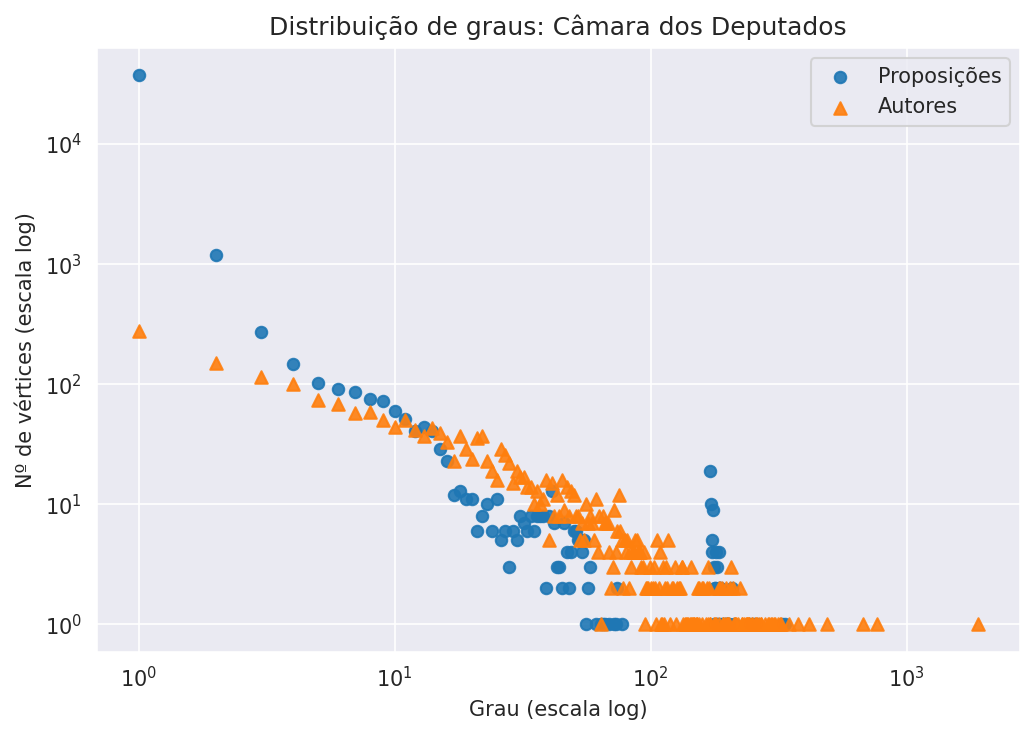

In [56]:


# Split nodes
bill_nodes   = [n for n, d in G.nodes(data=True) if n.startswith("P")]
author_nodes = [n for n, d in G.nodes(data=True) if n.startswith(("D", "O"))]

# Degree distributions
deg_bills   = Counter(dict(G.degree(bill_nodes)).values())
deg_authors = Counter(dict(G.degree(author_nodes)).values())

xs_b = sorted(deg_bills.keys())
ys_b = [deg_bills[x] for x in xs_b]

xs_a = sorted(deg_authors.keys())
ys_a = [deg_authors[x] for x in xs_a]


plt.figure(figsize=(7,5))

# Bills: circles
plt.scatter(xs_b, ys_b, marker="o", s=30, alpha=0.9, label="Proposições")

# Authors: triangles
plt.scatter(xs_a, ys_a, marker="^", s=36, alpha=0.9, label="Autores")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Grau (escala log)")
plt.ylabel("Nº de vértices (escala log)")
plt.title("Distribuição de graus: Câmara dos Deputados")
plt.legend()
plt.tight_layout()
plt.show()


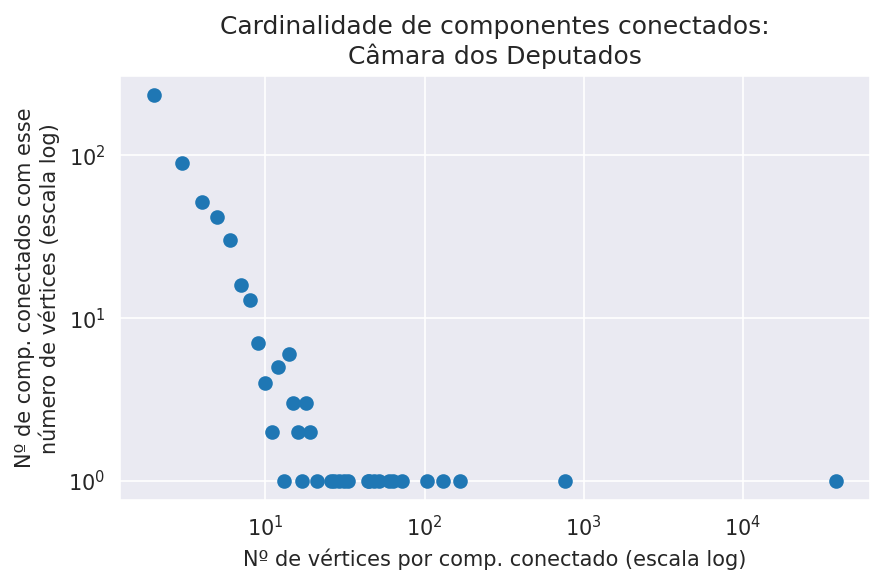

In [57]:
ccs = list(nx.connected_components(G))
cc_sizes = [len(cc) for cc in ccs]
cc_size_dist = Counter(cc_sizes)
xs = sorted(cc_size_dist.keys())
ys = [cc_size_dist[x] for x in xs]
plt.figure(figsize=(6,4))
plt.scatter(xs, ys)
plt.xlabel("Nº de vértices por comp. conectado (escala log)")
plt.ylabel("Nº de comp. conectados com esse\nnúmero de vértices (escala log)")
plt.xscale("log")
plt.yscale("log")
plt.title("Cardinalidade de componentes conectados:\nCâmara dos Deputados")
plt.tight_layout()
plt.show()

In [58]:
V = G.number_of_nodes()
E = G.number_of_edges()
k = 2 * E / V
print(f"|V| = {V}")
print(f"|E| = {E}")
print(f"<k> = {k}")
print(f"ccs = {len(ccs)}")


|V| = 42237
|E| = 74076
<k> = 3.507635485474821
ccs = 530


In [59]:
conn.close()

In [61]:
df.to_pickle("camara.pkl")